# Guided Project: Predicting House Sale Prices

In this guided project, we will explore ways to build and optimize linear models that can predict sale prices for houses.

We will work with a housing data for the city of Ames, Iowa, United States from 2006 to 2009. More information about the data is available [here](https://s3.amazonaws.com/dq-content/307/data_description.txt) and why the data was collected [here](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627).

In [311]:
# import important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [280]:
# Read in data
data = pd.read_csv('AmesHousing.tsv', delimiter = '\t')
data.head(3)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000


### Create, predict and test model performance

To automate this processes for multiple uses, let us create functions.

In [281]:
# Initialize reusable functions
def transform_features(df):
    return df

def select_features(df):
    return df[['Gr Liv Area','SalePrice']]

def train_and_test(df):
    train = df[:1460]
    test = df[1460:]
    
    #numeric columns
    numeric_train =train.select_dtypes(include ='number')
    numeric_test = test.select_dtypes(include = 'number')
    features = numeric_train.columns.drop('SalePrice')
    target = 'SalePrice'
    
    #fit
    lr = LinearRegression()
    model =lr.fit(train[features], train[target])
    
    #test
    preds = model.predict(test[features])
    rmse = (mean_squared_error(test[target], preds)) ** 0.5
    
    return rmse

In [282]:
# test the functions above
transform_df = transform_features(data)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

57088.25161263909

### Feature engineering

Here we will clean up the data by selecting important rows useful for linear model, removing and imputing missing values, selecting only numeric columns. And creating new important features that will improve our model performance.

In [283]:
# find columns where less than 5% of data are missing values
null_data =data.isnull().sum()
selected_cols =null_data[null_data < round(len(data) * 0.05)]
df = data[selected_cols.index]

In [284]:
df.head(3)

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,...,0,0,120,0,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,12500,6,2010,WD,Normal,172000


In [285]:
# Select numeric columns
numeric_cols =df[selected_cols.index].select_dtypes(include = 'number').columns
numeric_cols

Index(['Order', 'PID', 'MS SubClass', 'Lot Area', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces',
       'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF',
       'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val',
       'Mo Sold', 'Yr Sold', 'SalePrice'],
      dtype='object')

In [286]:
# Fill in missing values using mode for numerical vals
df = df.copy()
df[numeric_cols]=df.filter(numeric_cols).fillna(data.mode().iloc[0])
df.head(3)

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,...,0,0,120,0,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,0,12500,6,2010,WD,Normal,172000


In [287]:
# Confirm that all missing values have been imputed
df[numeric_cols].isnull().sum().value_counts()

0    37
dtype: int64

In [288]:
# Create new feature from the year built and year remod
df['years_used'] = df['Yr Sold'] - df['Year Built']
df['years_after_remod'] = df['Yr Sold'] - df['Year Remod/Add']

In [289]:
# Remove rows where year is negative
df[df['years_used'] < 0]

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,...,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,years_used,years_after_remod
2180,2181,908154195,20,RL,39290,Pave,IR1,Bnk,AllPub,Inside,...,0,0,17000,10,2007,New,Partial,183850,-1,-2


In [290]:
df[df['years_after_remod'] < 0]

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,...,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,years_used,years_after_remod
1702,1703,528120010,60,RL,16659,Pave,IR1,Lvl,AllPub,Corner,...,0,0,0,6,2007,New,Partial,260116,0,-1
2180,2181,908154195,20,RL,39290,Pave,IR1,Bnk,AllPub,Inside,...,0,0,17000,10,2007,New,Partial,183850,-1,-2
2181,2182,908154205,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,...,0,0,0,10,2007,New,Partial,184750,0,-1


In [291]:
# Drop rows with negative values for these new features
df = df.drop([1702, 2180, 2181], axis=0)

In [292]:
# Drop columns that are not needed
df = df.drop(["Year Built", "Year Remod/Add"], axis = 1)

# Drop columns that aren't useful for ML
df = df.drop(["PID", "Order"], axis=1)

# Drop columns that leak info about the final sale
df = df.drop(["Mo Sold", "Yr Sold"], axis=1)

In [293]:
df.head(3)

,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Sale Type,Sale Condition,SalePrice,years_used,years_after_remod
0,20,RL,31770,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,...,0,0,0,0,0,WD,Normal,215000,50,50
1,20,RH,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,0,0,120,0,0,WD,Normal,105000,49,49
2,20,RL,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,...,0,0,0,0,12500,WD,Normal,172000,52,52


In [294]:
def transform_features(data):
    '''
    Let us update the transform_features function created earlier with transformations
    implemented in the cells above.
    '''
    
    # find columns where less than 5% of data are missing values
    null_data =data.isnull().sum()
    selected_cols =null_data[null_data < round(len(data) * 0.05)]
    data = data[selected_cols.index]
    
    # Select numeric columns
    numeric_cols =data[selected_cols.index].select_dtypes(include = 'number').columns
    
    # Fill in missing values using mode for numerical vals
    data = data.copy()
    data[numeric_cols]=data.filter(numeric_cols).fillna(data.mode().iloc[0])
    
    # Create new feature from the year built and year remod
    data['years_used'] = data['Yr Sold'] - data['Year Built']
    data['years_after_remod'] = data['Yr Sold'] - data['Year Remod/Add']
    
    # Drop columns that are not needed
    data = data.drop(["Year Built", "Year Remod/Add", "PID", "Order", "Mo Sold", "Yr Sold"], axis = 1)
   
    # Drop rows with negative values for these new features
    data = data.drop([1702, 2180, 2181], axis=0)
    
    return data

In [295]:
# test the functions above
transform_df = transform_features(data)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

55275.36731241307

### Feature selection

Here, we selected the best features that will improve model performance;
Collinearity was checked and corrected. Only features that correlated with the target column (at 0.4 and above) were selected. Important categorical values were converted to dummy variables and used as features.

In [296]:
num_data = transform_df.select_dtypes(include = 'number')
num_data.head(3)

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,years_used,years_after_remod
0,20,31770,6,5,112.0,639.0,0.0,441.0,1080.0,1656,...,210,62,0,0,0,0,0,215000,50,50
1,20,11622,5,6,0.0,468.0,144.0,270.0,882.0,896,...,140,0,0,0,120,0,0,105000,49,49
2,20,14267,6,6,108.0,923.0,0.0,406.0,1329.0,1329,...,393,36,0,0,0,0,12500,172000,52,52


In [297]:
#Check correlation with sales column
corr = num_data.corr()['SalePrice'].sort_values(ascending =False)
corr

SalePrice            1.000000
Overall Qual         0.801206
Gr Liv Area          0.717596
Garage Cars          0.648361
Total Bsmt SF        0.644012
Garage Area          0.641425
1st Flr SF           0.635185
Full Bath            0.546118
Mas Vnr Area         0.506983
TotRms AbvGrd        0.498574
Fireplaces           0.474831
BsmtFin SF 1         0.439284
Wood Deck SF         0.328183
Open Porch SF        0.316262
Half Bath            0.284871
Bsmt Full Bath       0.276258
2nd Flr SF           0.269601
Lot Area             0.267520
Bsmt Unf SF          0.182751
Bedroom AbvGr        0.143916
Screen Porch         0.112280
Pool Area            0.068438
3Ssn Porch           0.032268
BsmtFin SF 2         0.006127
Misc Val            -0.019273
Bsmt Half Bath      -0.035875
Low Qual Fin SF     -0.037629
MS SubClass         -0.085128
Overall Cond        -0.101540
Kitchen AbvGr       -0.119760
Enclosed Porch      -0.128685
years_after_remod   -0.534985
years_used          -0.558979
Name: Sale

In [298]:
#Select columns with correlation greater than 0.4
num_data =num_data[corr[corr > 0.4].index]
num_data.head(3)

,SalePrice,Overall Qual,Gr Liv Area,Garage Cars,Total Bsmt SF,Garage Area,1st Flr SF,Full Bath,Mas Vnr Area,TotRms AbvGrd,Fireplaces,BsmtFin SF 1
0,215000,6,1656,2.0,1080.0,528.0,1656,1,112.0,7,2,639.0
1,105000,5,896,1.0,882.0,730.0,896,1,0.0,5,0,468.0
2,172000,6,1329,1.0,1329.0,312.0,1329,1,108.0,6,0,923.0


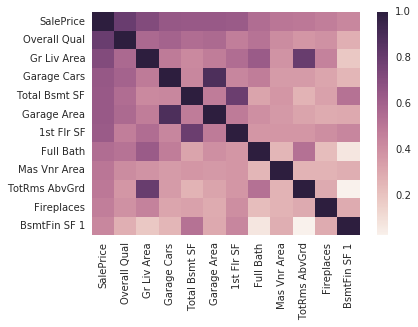

In [299]:
import seaborn as sns
%matplotlib inline
sns.heatmap(num_data.corr())

There seem to be collinearity among the features,
* Gr Liv Area and TotRms AbvGrd
* Garage Area and Garage Cars

To solve this problem, we delete one feature from each pair

In [300]:
num_data = num_data.drop(columns = ['TotRms AbvGrd', 'Garage Cars'])

In [301]:
# Create a list of column names from documentation that are *meant* to be categorical
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

In [302]:
# Which categorical columns have we still carried with us? We'll test these 
transform_cat_cols = []
for col in nominal_features:
    if col in transform_df.columns:
        transform_cat_cols.append(col)

# How many unique values in each categorical column?
uniqueness_counts = transform_df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
# Aribtrary cutoff of 10 unique values (worth experimenting)
drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
transform_df = transform_df.drop(drop_nonuniq_cols, axis=1)


# Select just the remaining text columns and convert to categorical
text_cols = transform_df.select_dtypes(include=['object'])
for col in text_cols:
    transform_df[col] = transform_df[col].astype('category')
    
# Create dummy columns and add back to the dataframe!
transform_df = pd.concat([
    transform_df, 
    pd.get_dummies(transform_df.select_dtypes(include=['category']))
], axis=1).drop(text_cols,axis=1)

Now let us update the select_feature function with the updates from preceeding cells

In [304]:
def select_features(df, coeff_threshold=0.4, uniq_threshold=10):
    numerical_df = df.select_dtypes(include=['int', 'float'])
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs < coeff_threshold].index, axis=1)
    
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)

    uniqueness_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    drop_nonuniq_cols = uniqueness_counts[uniqueness_counts > 10].index
    df = df.drop(drop_nonuniq_cols, axis=1)
    
    text_cols = df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    df = pd.concat([df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1).drop(text_cols,axis=1)
    
    return df

In [306]:
# test the model performance after tuning features above
transform_df = transform_features(data)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

33090.83173838363

In [307]:
### Checking model performance with cross validation 

In [350]:
def train_and_test(df, k =0):
    lr = LinearRegression()
    #numeric columns
    numeric_df = df.select_dtypes(include=['integer', 'float'])
    features = numeric_df.columns.drop("SalePrice")
    target = 'SalePrice'
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]
    
        #fit
        model =lr.fit(train[features], train[target])
    
        #test
        preds = model.predict(test[features])
        rmse = (mean_squared_error(test[target], preds)) ** 0.5
    
        return rmse
    
    
    elif k ==1:
        # Shuffle rows
        shuffled_df = df.sample(frac=1, )
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features], train["SalePrice"])
        predictions_one = lr.predict(test[features])        
        
        mse_one = mean_squared_error(test["SalePrice"], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(test[features], test["SalePrice"])
        predictions_two = lr.predict(train[features])        
       
        mse_two = mean_squared_error(train["SalePrice"], predictions_two)
        rmse_two = np.sqrt(mse_two)
        
        avg_rmse = np.mean([rmse_one, rmse_two])
        #print(rmse_one)
        #print(rmse_two)
        return avg_rmse
    
    
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        #print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse
    

### Checking model performance at different KFoldsrmse = train_and_test(filtered_df, 4)

rmse

In [356]:
transform_df = transform_features(data)
filtered_df = select_features(transform_df)

In [359]:
#Trying different KFolds to find the best performance
results = {}
for k in range(20):
    res = train_and_test(filtered_df, k = k)
    results[k] = res
results  

{0: 33090.83173838363,
 1: 29195.730391268655,
 2: 28701.811691207124,
 3: 28300.79629640751,
 4: 27965.242914079277,
 5: 27320.916325524537,
 6: 27701.376666697335,
 7: 27193.243160483868,
 8: 27399.265074055264,
 9: 26967.81847952434,
 10: 27032.999177324768,
 11: 27142.546765825737,
 12: 27026.81626191962,
 13: 26657.74792810533,
 14: 26868.284605390752,
 15: 26647.632009377197,
 16: 26594.69671473631,
 17: 26597.01681904504,
 18: 26485.551704278674,
 19: 26162.566893434803}

### Conclusion

The values from results above are K- values with the corresponding RMSE values. With feature engineering, feature selection and adjusting KFolds, it is evident that the model got better. Hence it is important to do necessary cleaning and preprocessing before fitting and testing a model. For this project. Models at K=13 and above perfom better than the others. However, at k = 9 computational power could be saved for a decent performing model. 

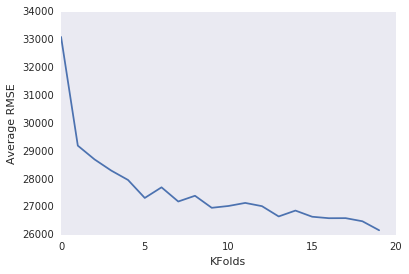

In [374]:
names = list(results.keys())
values = list(results.values())
      
plt.plot(names, values)
plt.xlabel('KFolds')
plt.ylabel('Average RMSE')
plt.grid(b=None)
plt.show()